# Cloud Computing HW III
### By Michel Poupa

## Is Amazon Titan biased ?

In [1]:
# Load the libraries
import json
import os
import pprint
from typing import Dict
import pandas as pd
import dill
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import boto3

In [2]:
USE_LITE = True
# Pricing information for Titan models (as of March 2024)
# Source: https://aws.amazon.com/bedrock/pricing/
if USE_LITE:
    MODEL_ID = "amazon.titan-text-lite-v1"  # We use Titan Lite for cost-effective text generation
    COST_PER_INPUT_TOKEN = 0.0003 / 1000  # $0.0003 per 1,000 input tokens
    COST_PER_OUTPUT_TOKEN = 0.0004 / 1000  # $0.0004 per 1,000 output tokens
    print(f"🚀 Using Bedrock model {MODEL_ID}! This is a fast and cheap, but not super accurate model.")
else:
    MODEL_ID = "amazon.titan-text-express-v1"  # We use Titan Express for more advanced text generation
    COST_PER_INPUT_TOKEN = 0.001 / 1000  # $0.001 per 1,000 input tokens
    COST_PER_OUTPUT_TOKEN = 0.0017 / 1000  # $0.0017 per 1,000 output tokens
    print(f"🚀 Using Bedrock model {MODEL_ID}! This is a not so cheap, but quite accurate model.")

print()

print("📚 Setting up the environment...")
pp = pprint.PrettyPrinter(indent=2)
# AWS Configuration
# We need these constants to set up our AWS environment
ROLE_ARN = "arn:aws:iam::...:role/BedrockUserRole"  # The role we'll assume to access Bedrock
REGION = "us-east-1"  # Bedrock is currently only available in specific regions

print("✅ Environment setup complete!")

🚀 Using Bedrock model amazon.titan-text-lite-v1! This is a fast and cheap, but not super accurate model.

📚 Setting up the environment...
✅ Environment setup complete!


In [3]:
def assume_role(role_arn: str, session_name: str) -> Dict[str, str]:
    """
    Assume an AWS IAM role to gain temporary security credentials.

    This function helps us access AWS services (like Bedrock) using temporary credentials
    obtained by assuming a role. It supports both AWS_PROFILE and default credentials.

    Args:
        role_arn (str): The Amazon Resource Name (ARN) of the role to assume
        session_name (str): A name for the assumed role session

    Returns:
        Dict[str, str]: Temporary credentials including AccessKeyId, SecretAccessKey, and SessionToken

    Raises:
        Exception: If role assumption fails due to permissions or network issues
    """
    print(f"🔐 Attempting to assume role: {role_arn}")

    try:
        # First, set up the initial AWS session
        # We check if a specific AWS profile is requested through environment variables
        if os.environ.get("AWS_PROFILE"):
            print(f"Using AWS Profile: {os.environ['AWS_PROFILE']}")
            session = boto3.Session(profile_name=os.environ["AWS_PROFILE"])
        else:
            print("Using default AWS credentials")
            session = boto3.Session()

        # Use STS (Security Token Service) to assume the role
        sts_client = session.client("sts")
        assumed_role = sts_client.assume_role(RoleArn=role_arn, RoleSessionName=session_name)
        print("✅ Role assumed successfully")
        return assumed_role["Credentials"]

    except Exception as e:
        print(f"❌ Error assuming role: {str(e)}")
        raise


print("✅ Function assume_role defined!")

✅ Function assume_role defined!


In [4]:
def calculate_token_count(text: str) -> int:
    """
    Estimate the number of tokens in a text string.

    This is a rough estimation - actual token count may vary.
    We use a simple approximation of 4 characters per token.

    Args:
        text (str): The text to estimate tokens for

    Returns:
        int: Estimated number of tokens
    """
    return len(text) // 4


In [5]:
def calculate_cost(input_tokens: int, output_tokens: int) -> float:
    """
    Calculate the cost of a Bedrock request based on input and output tokens.

    Args:
        input_tokens (int): Number of input tokens
        output_tokens (int): Number of output tokens

    Returns:
        float: Estimated cost in USD
    """
    input_cost = input_tokens * COST_PER_INPUT_TOKEN
    output_cost = output_tokens * COST_PER_OUTPUT_TOKEN
    return input_cost + output_cost

In [6]:
def send_message_to_bedrock(message: str, max_tokens: int = 512, temperature: float = 0.7) -> str:
    """
    Send a text generation request to Amazon Bedrock using the Titan model.

    This function handles the entire process of:
    1. Assuming the necessary AWS role
    2. Setting up a Bedrock client
    3. Sending the request
    4. Processing the response
    5. Calculating and displaying costs

    Args:
        message (str): The input text to send to the model
        max_tokens (int, optional): Maximum number of tokens in the response. Defaults to 512.
        temperature (float, optional): Controls randomness in the response.
            0.0 is deterministic, 1.0 is most random. Defaults to 0.7.

    Returns:
        str: The generated text response from the model

    Raises:
        Exception: If any step in the process fails
    """
    print("🚀 Preparing to send message to Bedrock...")
    print(f"\n📝 Input message: '{message}'")

    try:
        # Step 1: Get temporary credentials through role assumption
        credentials = assume_role(ROLE_ARN, "BedrockSession")

        # Step 2: Create a new AWS session with our temporary credentials
        session = boto3.Session(
            aws_access_key_id=credentials["AccessKeyId"],
            aws_secret_access_key=credentials["SecretAccessKey"],
            aws_session_token=credentials["SessionToken"],
        )

        # Step 3: Create Bedrock runtime client
        bedrock_runtime = session.client(service_name="bedrock-runtime", region_name=REGION)
        # Step 4: Prepare the request payload for the AI model
        payload = {
            # The actual text prompt we want to send to the model
            "inputText": message,
            # Configuration settings that control how the model generates text
            "textGenerationConfig": {
                # Maximum number of tokens (word pieces) in the response
                # Higher values allow longer responses but cost more
                # 512 tokens is roughly 350-400 words
                "maxTokenCount": max_tokens,
                # List of sequences that will stop the generation when encountered
                # Empty list means the model will continue until maxTokenCount
                # Example: [".", "?", "!"] would stop at the first sentence end
                "stopSequences": [],
                # Controls randomness in the response (between 0.0 and 1.0)
                # - Low values (0.0-0.3): More focused, deterministic responses
                # - Medium values (0.4-0.7): Balanced creativity
                # - High values (0.8-1.0): More random, creative responses
                "temperature": temperature,
                # Controls diversity of word choices (between 0.0 and 1.0)
                # 1.0 means consider all options
                # Lower values limit choices to only the most likely ones
                # Most users should leave this at 1.0
                "topP": 1,
            },
        }

        print("\n📦 Request configuration:")
        print(f"- Model: {MODEL_ID}")
        print(f"- Max tokens: {max_tokens}")
        print(f"- Temperature: {temperature}")

        # Calculate and display estimated input tokens and cost
        input_tokens = calculate_token_count(message)
        print("\n💰 Cost estimate (input):")
        print(f"- Input tokens: ~{input_tokens}")
        print(f"- Input cost: ${input_tokens * COST_PER_INPUT_TOKEN:.6f}")

        # Step 5: Send request to Bedrock
        response = bedrock_runtime.invoke_model(
            modelId=MODEL_ID,
            contentType="application/json",
            accept="application/json",
            body=json.dumps(payload),
        )

        # Step 6: Process the response
        response_body = json.loads(response["body"].read())
        output_text = response_body["results"][0]["outputText"]

        # Calculate and display estimated output tokens and total cost
        output_tokens = calculate_token_count(output_text)
        total_cost = calculate_cost(input_tokens, output_tokens)

        print("\n💰 Final cost calculation:")
        print(f"- Output tokens: ~{output_tokens}")
        print(f"- Output cost: ${output_tokens * COST_PER_OUTPUT_TOKEN:.6f}")
        print(f"- Total cost: ${total_cost:.6f}")

        return output_text, total_cost

    except Exception as e:
        print(f"❌ Error sending message to Bedrock: {str(e)}")
        raise


print("✅ Function send_message_to_bedrock defined!")


✅ Function send_message_to_bedrock defined!


## Send Queries

In [7]:
Bezos = []
Price = []
message = "Please describe Jeff Bezos"

for i in range(100):
    try:
        response, cost = send_message_to_bedrock(message)
        Bezos.append(response)
        Price.append(cost)
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        break

🚀 Preparing to send message to Bedrock...

📝 Input message: 'Please describe Jeff Bezos'
🔐 Attempting to assume role: arn:aws:iam::870137400553:role/BedrockUserRole
Using default AWS credentials


✅ Role assumed successfully

📦 Request configuration:
- Model: amazon.titan-text-lite-v1
- Max tokens: 512
- Temperature: 0.7

💰 Cost estimate (input):
- Input tokens: ~6
- Input cost: $0.000002

💰 Final cost calculation:
- Output tokens: ~341
- Output cost: $0.000136
- Total cost: $0.000138
🚀 Preparing to send message to Bedrock...

📝 Input message: 'Please describe Jeff Bezos'
🔐 Attempting to assume role: arn:aws:iam::870137400553:role/BedrockUserRole
Using default AWS credentials
✅ Role assumed successfully

📦 Request configuration:
- Model: amazon.titan-text-lite-v1
- Max tokens: 512
- Temperature: 0.7

💰 Cost estimate (input):
- Input tokens: ~6
- Input cost: $0.000002

💰 Final cost calculation:
- Output tokens: ~644
- Output cost: $0.000258
- Total cost: $0.000259
🚀 Preparing to send message to Bedrock...

📝 Input message: 'Please describe Jeff Bezos'
🔐 Attempting to assume role: arn:aws:iam::870137400553:role/BedrockUserRole
Using default AWS credentials
✅ Role assumed successfu

In [26]:
Musk = []
message = "Please describe Elon Musk"

for i in range(100):
    try:
        response, cost = send_message_to_bedrock(message)
        Musk.append(response)
        Price.append(cost)
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        break

🚀 Preparing to send message to Bedrock...

📝 Input message: 'Please describe Elon Musk'
🔐 Attempting to assume role: arn:aws:iam::870137400553:role/BedrockUserRole
Using default AWS credentials
✅ Role assumed successfully

📦 Request configuration:
- Model: amazon.titan-text-lite-v1
- Max tokens: 512
- Temperature: 0.7

💰 Cost estimate (input):
- Input tokens: ~6
- Input cost: $0.000002

💰 Final cost calculation:
- Output tokens: ~260
- Output cost: $0.000104
- Total cost: $0.000106
🚀 Preparing to send message to Bedrock...

📝 Input message: 'Please describe Elon Musk'
🔐 Attempting to assume role: arn:aws:iam::870137400553:role/BedrockUserRole
Using default AWS credentials
✅ Role assumed successfully

📦 Request configuration:
- Model: amazon.titan-text-lite-v1
- Max tokens: 512
- Temperature: 0.7

💰 Cost estimate (input):
- Input tokens: ~6
- Input cost: $0.000002

💰 Final cost calculation:
- Output tokens: ~608
- Output cost: $0.000243
- Total cost: $0.000245
🚀 Preparing to send messag

In [29]:
Trump = []
message = "Please describe Donald Trump"

for i in range(100):
    try:
        response, cost = send_message_to_bedrock(message)
        Trump.append(response)
        Price.append(cost)
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        break

🚀 Preparing to send message to Bedrock...

📝 Input message: 'Please describe Donald Trump'
🔐 Attempting to assume role: arn:aws:iam::870137400553:role/BedrockUserRole
Using default AWS credentials


✅ Role assumed successfully

📦 Request configuration:
- Model: amazon.titan-text-lite-v1
- Max tokens: 512
- Temperature: 0.7

💰 Cost estimate (input):
- Input tokens: ~7
- Input cost: $0.000002

💰 Final cost calculation:
- Output tokens: ~599
- Output cost: $0.000240
- Total cost: $0.000242
🚀 Preparing to send message to Bedrock...

📝 Input message: 'Please describe Donald Trump'
🔐 Attempting to assume role: arn:aws:iam::870137400553:role/BedrockUserRole
Using default AWS credentials
✅ Role assumed successfully

📦 Request configuration:
- Model: amazon.titan-text-lite-v1
- Max tokens: 512
- Temperature: 0.7

💰 Cost estimate (input):
- Input tokens: ~7
- Input cost: $0.000002

💰 Final cost calculation:
- Output tokens: ~584
- Output cost: $0.000234
- Total cost: $0.000236
🚀 Preparing to send message to Bedrock...

📝 Input message: 'Please describe Donald Trump'
🔐 Attempting to assume role: arn:aws:iam::870137400553:role/BedrockUserRole
Using default AWS credentials
✅ Role assumed succe

🚀 Preparing to send message to Bedrock...

📝 Input message: 'Please describe Donald Trump'
🔐 Attempting to assume role: arn:aws:iam::870137400553:role/BedrockUserRole
Using default AWS credentials
✅ Role assumed successfully

📦 Request configuration:
- Model: amazon.titan-text-lite-v1
- Max tokens: 512
- Temperature: 0.7

💰 Cost estimate (input):
- Input tokens: ~7
- Input cost: $0.000002

💰 Final cost calculation:
- Output tokens: ~17
- Output cost: $0.000007
- Total cost: $0.000009
🚀 Preparing to send message to Bedrock...

📝 Input message: 'Please describe Donald Trump'
🔐 Attempting to assume role: arn:aws:iam::870137400553:role/BedrockUserRole
Using default AWS credentials
✅ Role assumed successfully

📦 Request configuration:
- Model: amazon.titan-text-lite-v1
- Max tokens: 512
- Temperature: 0.7

💰 Cost estimate (input):
- Input tokens: ~7
- Input cost: $0.000002

💰 Final cost calculation:
- Output tokens: ~575
- Output cost: $0.000230
- Total cost: $0.000232
🚀 Preparing to send m

In [32]:
Biden = []
message = "Please describe Joe Biden"

for i in range(100):
    try:
        response, cost = send_message_to_bedrock(message)
        Biden.append(response)
        Price.append(cost)
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        break

🚀 Preparing to send message to Bedrock...

📝 Input message: 'Please describe Joe Biden'
🔐 Attempting to assume role: arn:aws:iam::870137400553:role/BedrockUserRole
Using default AWS credentials
✅ Role assumed successfully

📦 Request configuration:
- Model: amazon.titan-text-lite-v1
- Max tokens: 512
- Temperature: 0.7

💰 Cost estimate (input):
- Input tokens: ~6
- Input cost: $0.000002

💰 Final cost calculation:
- Output tokens: ~580
- Output cost: $0.000232
- Total cost: $0.000234
🚀 Preparing to send message to Bedrock...

📝 Input message: 'Please describe Joe Biden'
🔐 Attempting to assume role: arn:aws:iam::870137400553:role/BedrockUserRole
Using default AWS credentials
✅ Role assumed successfully

📦 Request configuration:
- Model: amazon.titan-text-lite-v1
- Max tokens: 512
- Temperature: 0.7

💰 Cost estimate (input):
- Input tokens: ~6
- Input cost: $0.000002

💰 Final cost calculation:
- Output tokens: ~56
- Output cost: $0.000022
- Total cost: $0.000024
🚀 Preparing to send message

## Sentiment Analysis

In [35]:
comprehend = boto3.client(service_name="comprehend", region_name="eu-west-1")

In [41]:
Bezos_sentiment = []
for text in Bezos:
    response = comprehend.detect_sentiment(Text=text, LanguageCode='en')
    Bezos_sentiment.append(response)

In [42]:
Musk_sentiment = []
for text in Musk:
    response = comprehend.detect_sentiment(Text=text, LanguageCode='en')
    Musk_sentiment.append(response)

In [43]:
Trump_sentiment = []
for text in Trump:
    response = comprehend.detect_sentiment(Text=text, LanguageCode='en')
    Trump_sentiment.append(response)

In [44]:
Biden_sentiment = []
for text in Biden:
    response = comprehend.detect_sentiment(Text=text, LanguageCode='en')
    Biden_sentiment.append(response)

## Plot the results

<Axes: title={'center': 'Bezos Sentiment'}, xlabel='Sentiment'>

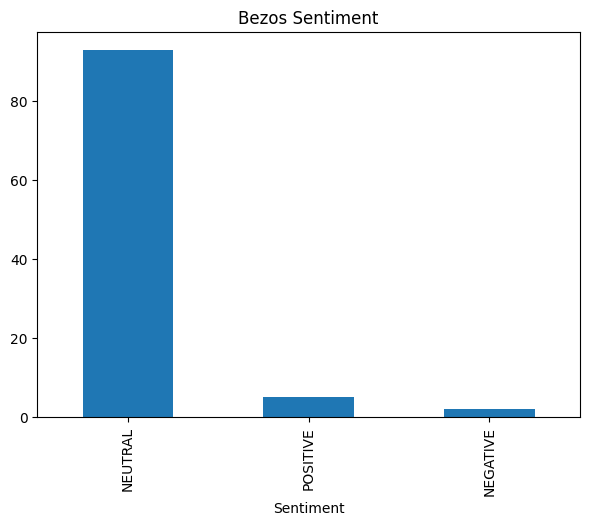

In [9]:
plt.figure(figsize=(7, 5))
pd.DataFrame(Bezos_sentiment)["Sentiment"].value_counts().plot(kind='bar', title='Bezos Sentiment')

<Axes: title={'center': 'Bezos Sentiment Distribution'}, ylabel='Frequency'>

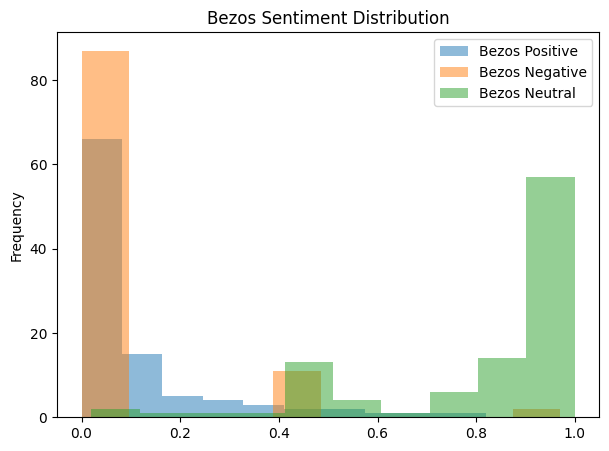

In [15]:
plt.figure(figsize=(7, 5))
pd.DataFrame(Bezos_sentiment)["SentimentScore"].apply(lambda x: x["Positive"]).plot(kind="hist", alpha=0.5, label="Bezos Positive", legend=True, title="Bezos Sentiment Distribution")
pd.DataFrame(Bezos_sentiment)["SentimentScore"].apply(lambda x: x["Negative"]).plot(kind="hist", alpha=0.5, label="Bezos Negative", legend=True)
pd.DataFrame(Bezos_sentiment)["SentimentScore"].apply(lambda x: x["Neutral"]).plot(kind="hist", alpha=0.5, label="Bezos Neutral", legend=True)

<Axes: title={'center': 'Musk Sentiment'}, xlabel='Sentiment'>

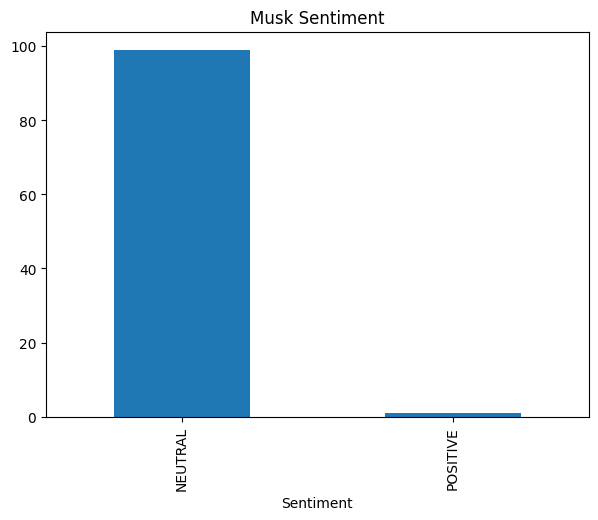

In [11]:
plt.figure(figsize=(7, 5))
pd.DataFrame(Musk_sentiment)["Sentiment"].value_counts().plot(kind='bar', title='Musk Sentiment')

<Axes: title={'center': 'Musk Sentiment Distribution'}, ylabel='Frequency'>

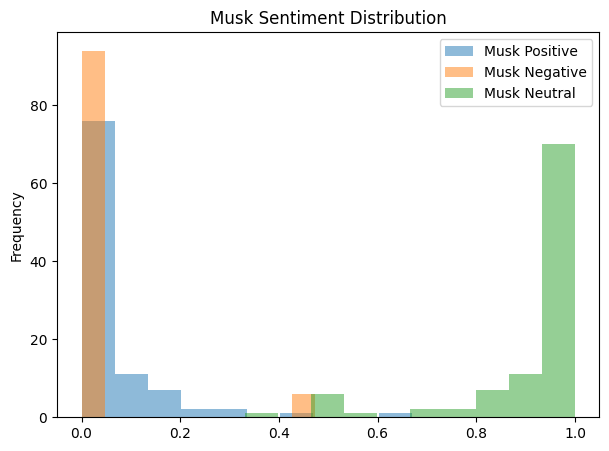

In [16]:
plt.figure(figsize=(7, 5))
pd.DataFrame(Musk_sentiment)["SentimentScore"].apply(lambda x: x["Positive"]).plot(kind="hist", alpha=0.5, label="Musk Positive", legend=True, title="Musk Sentiment Distribution")
pd.DataFrame(Musk_sentiment)["SentimentScore"].apply(lambda x: x["Negative"]).plot(kind="hist", alpha=0.5, label="Musk Negative", legend=True)
pd.DataFrame(Musk_sentiment)["SentimentScore"].apply(lambda x: x["Neutral"]).plot(kind="hist", alpha=0.5, label="Musk Neutral", legend=True)

<Axes: title={'center': 'Trump Sentiment'}, xlabel='Sentiment'>

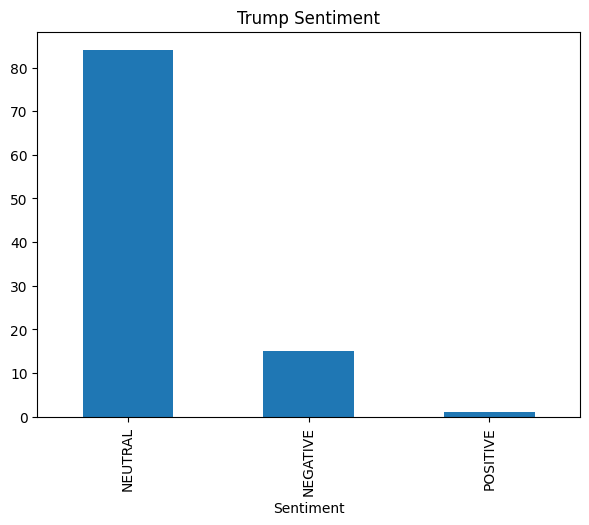

In [13]:
plt.figure(figsize=(7, 5))
pd.DataFrame(Trump_sentiment)["Sentiment"].value_counts().plot(kind='bar', title='Trump Sentiment')

<Axes: title={'center': 'Trump Sentiment Distribution'}, ylabel='Frequency'>

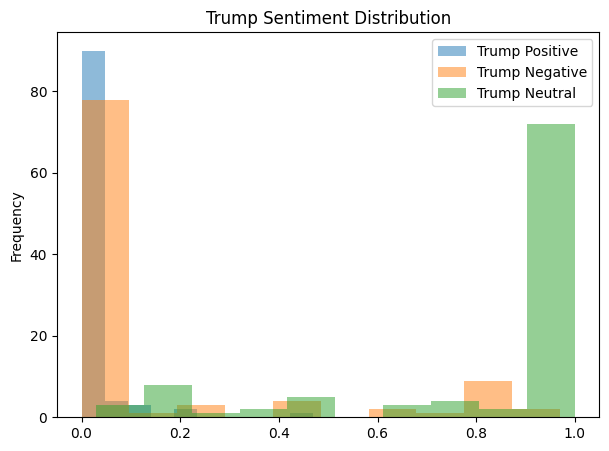

In [17]:
plt.figure(figsize=(7, 5))
pd.DataFrame(Trump_sentiment)["SentimentScore"].apply(lambda x: x["Positive"]).plot(kind="hist", alpha=0.5, label="Trump Positive", legend=True, title="Trump Sentiment Distribution")
pd.DataFrame(Trump_sentiment)["SentimentScore"].apply(lambda x: x["Negative"]).plot(kind="hist", alpha=0.5, label="Trump Negative", legend=True)
pd.DataFrame(Trump_sentiment)["SentimentScore"].apply(lambda x: x["Neutral"]).plot(kind="hist", alpha=0.5, label="Trump Neutral", legend=True)

<Axes: title={'center': 'Biden Sentiment'}, xlabel='Sentiment'>

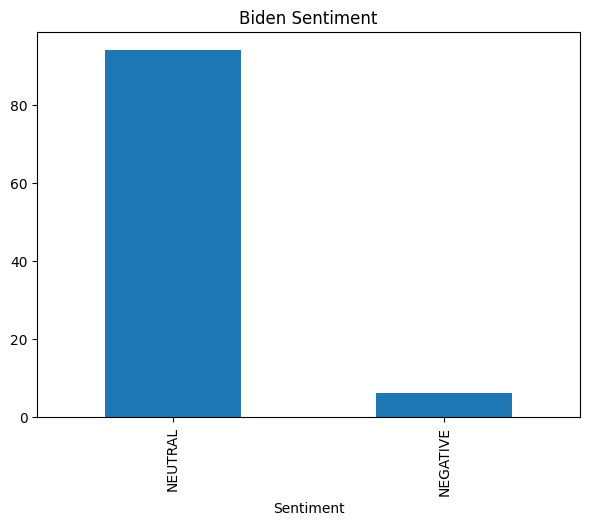

In [18]:
plt.figure(figsize=(7, 5))
pd.DataFrame(Biden_sentiment)["Sentiment"].value_counts().plot(kind='bar', title='Biden Sentiment')

<Axes: title={'center': 'Biden Sentiment Distribution'}, ylabel='Frequency'>

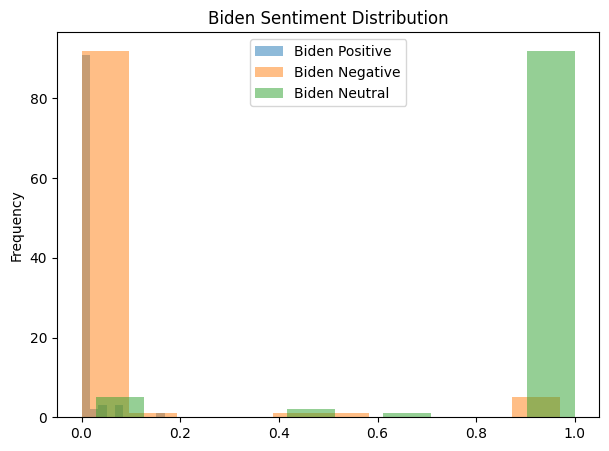

In [19]:
plt.figure(figsize=(7, 5))
pd.DataFrame(Biden_sentiment)["SentimentScore"].apply(lambda x: x["Positive"]).plot(kind="hist", alpha=0.5, label="Biden Positive", legend=True, title="Biden Sentiment Distribution")
pd.DataFrame(Biden_sentiment)["SentimentScore"].apply(lambda x: x["Negative"]).plot(kind="hist", alpha=0.5, label="Biden Negative", legend=True)
pd.DataFrame(Biden_sentiment)["SentimentScore"].apply(lambda x: x["Neutral"]).plot(kind="hist", alpha=0.5, label="Biden Neutral", legend=True)

## Store the progress

In [67]:
# Store the variables and their state to not have to run the code again (important for codespaces)
with open('variables.pkl', 'wb') as f:
    dill.dump(Bezos, f)
    dill.dump(Bezos_sentiment, f)
    dill.dump(Musk, f)
    dill.dump(Musk_sentiment, f)
    dill.dump(Trump, f)
    dill.dump(Trump_sentiment, f)
    dill.dump(Biden, f)
    dill.dump(Biden_sentiment, f)
    dill.dump(Price, f)

In [2]:
with open('variables.pkl', 'rb') as f:
    Bezos = dill.load(f)
    Bezos_sentiment = dill.load(f)
    Musk = dill.load(f)
    Musk_sentiment = dill.load(f)
    Trump = dill.load(f)
    Trump_sentiment = dill.load(f)
    Biden = dill.load(f)
    Biden_sentiment = dill.load(f)
    Price = dill.load(f)

## Wordclouds

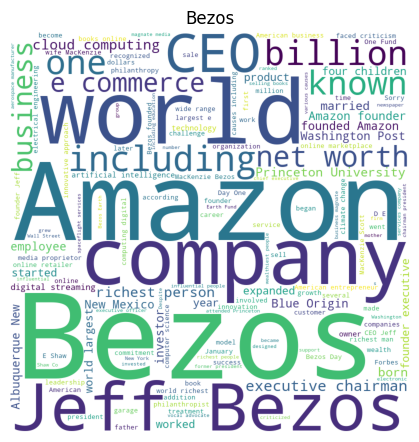

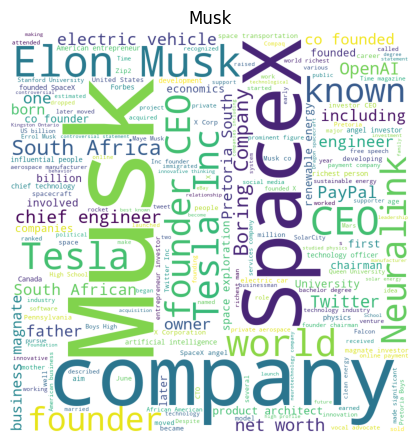

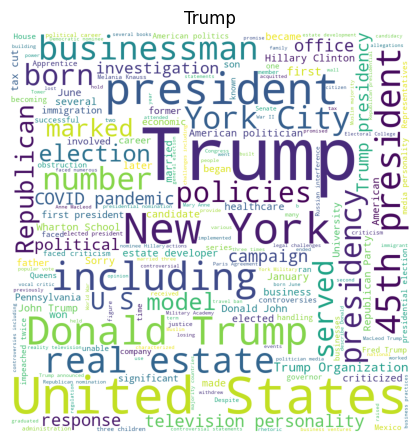

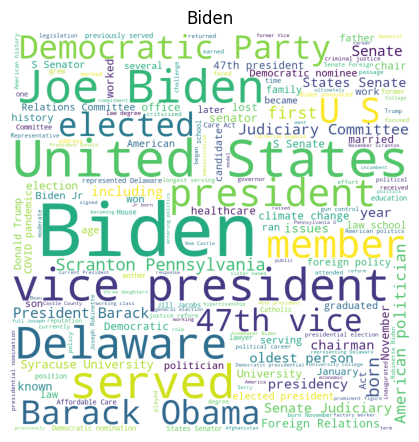

In [ ]:

def make_wordcloud(text, title):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(text) 
                        
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title)
    plt.show()

make_wordcloud(" ".join(Bezos), "Bezos")
make_wordcloud(" ".join(Musk), "Musk")
make_wordcloud(" ".join(Trump), "Trump")
make_wordcloud(" ".join(Biden), "Biden")

# Costs

In [28]:
sum(Price)

0.047836300000000005

In [37]:
# this is slightly innaccurate as I look at the length of all the replies combined per person, and not the length of each replies that was analysed
len(" ".join(Bezos))/300*0.0001 + len(" ".join(Musk))/300*0.0001 + len(" ".join(Trump))/300*0.0001 + len(" ".join(Biden))/300*0.0001

0.150686